In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = "/content/NGAsub_MegaFlatfile_RotD50_050_R211022_public.xlsx"
df = pd.read_excel(file_path)

In [ ]:
df.columns

Index(['NGAsubRSN', 'DatabaseRegion', 'NGAsubEQID', 'NGAsubSSN',
       'Earthquake_Name', 'YEAR', 'MODY', 'HRMN', 'Earthquake_Magnitude',
       'Hypocenter_Latitude_deg',
       ...
       'T8pt500S', 'T9pt000S', 'T9pt500S', 'T10pt000S', 'T11pt000S',
       'T12pt000S', 'T13pt000S', 'T14pt000S', 'T15pt000S', 'T20pt000S'],
      dtype='object', length=227)

In [ ]:
df.rename(columns={
    'PGA_g': 'pga',
    'Earthquake_Magnitude': 'mag',
    'Rjb_km': 'rjb',
    'Hypocenter_Depth_km': 'hypd',
    'Vs30_Selected_for_Analysis_m_s': 'vs30',
    'Intra_Inter_Flag': 'intra_inter',
    'Sensor_Depth_m': 'sensor_depth',
    'Multiple_Event': 'multi_event',
    'Late_P_trigger_flag_1ptYes_0ptNo': 'late_flag',
    'Source_review_flag': 'src_flag',
    'Longest_Usable_Period_for_PSa_Ave_Component_sec': 'tgm',
    'NGAsubEQID': 'EqID',
    'Station_Name':'siteID'
}, inplace=True)

In [ ]:
df = df[(df['pga'] != -999) & (df['pga'] <= 10) & (df['mag'] >= 4)]

meta_cols = ['mag', 'rjb', 'hypd', 'vs30',"Ztor_km"]
for col in meta_cols:
    df = df[df[col] != -999]

df = df[df['intra_inter'].isin([0, 1, 5])]

is_interface = (df['intra_inter'] == 0) & (df['hypd'] < 40)
is_intraslab = (df['intra_inter'] == 1) & (df['hypd'] < 200)
df = df[is_interface | is_intraslab]

df = df[df['rjb'] <= 1000]

df = df[df['sensor_depth'] <= 2]

df = df[df['multi_event'] != 1]

df = df[df['late_flag'] != 1]

df = df[df['src_flag'].isin([0, 1, 2, 4])]

df = df[df['tgm'] >= 10]

event_counts = df['EqID'].value_counts()
valid_eids = event_counts[event_counts >= 3].index
df = df[df['EqID'].isin(valid_eids)]
df.shape

(14526, 227)

In [ ]:
df.drop_duplicates()
df.shape

(14526, 227)

In [ ]:
df.Geomatrix_Site_Code_1st_Letter.unique()

array(['-999', 'C'], dtype=object)

In [ ]:
input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']
target_cols = [
    "T0pt010S", "T0pt020S", "T0pt030S", "T0pt050S", "T0pt075S",
    "T0pt100S", "T0pt150S", "T0pt200S", "T0pt300S", "T0pt400S",
    "T0pt500S", "T0pt750S", "T1pt000S", "T1pt500S", "T2pt000S",
    "T2pt500S", "T3pt000S", "T3pt500S", "T4pt000S", "T5pt000S"
]

df['rjb'] = df['rjb'].replace(0, 0.01).replace([np.inf, -np.inf], np.nan)
df['vs30'] = df['vs30'].astype(float).replace(0, 0.01).replace([np.inf, -np.inf], np.nan)

# Log-transform rjb and vs30
df['logrjb'] = np.log10(df['rjb'])
df['logvs30'] = np.log10(df['vs30'])

# Drop any rows with NaN
df = df.dropna(subset=input_cols + target_cols)

# Extract inputs and targets
inputs = df[input_cols].values
targets = df[target_cols].values

# >>>>> Correct: Apply natural log to targets <<<<<
targets = np.log(targets)

# Normalize inputs and targets separately
scaler_input = StandardScaler()
scaler_target = StandardScaler()

inputs_scaled = scaler_input.fit_transform(inputs)
targets_scaled = scaler_target.fit_transform(targets)

# Save EqID and SiteID for residual calculations
EqIDs = df['EqID'].values
siteIDs = df['siteID'].values

# Train-validation-test split (randomized split)
X_train, X_temp, y_train, y_temp, EqID_train, EqID_temp, siteID_train, siteID_temp = train_test_split(
    inputs_scaled, targets_scaled, EqIDs, siteIDs, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test, EqID_val, EqID_test, siteID_val, siteID_test = train_test_split(
    X_temp, y_temp, EqID_temp, siteID_temp, test_size=0.5, random_state=42)


In [ ]:
def build_ann(input_dim, output_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dense(output_dim)
    ])

NoOfOutput = targets.shape[1]
model = build_ann(X_train.shape[1], NoOfOutput)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse', metrics=['mae'])

max_iterations = 15
LH = np.zeros((max_iterations, NoOfOutput))
LHR = np.zeros((max_iterations, NoOfOutput))

best_model = model # Initialize best_model with the initial model
best_iteration = 0
min_val_loss = float('inf') # Initialize with a large value

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=50, restore_best_weights=True)

for iteration in range(max_iterations):
    print(f"\n--- Iteration {iteration+1}/{max_iterations} ---")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=2000, batch_size=32, verbose=0, callbacks=[early_stopping])

    val_loss = history.history['val_loss'][-1] # Get the final validation loss

    # Update best_model if current model has lower validation loss
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_model = model # Assign the current model as the best model
        best_iteration = iteration + 1 # Update best iteration

    # Predict on full data
    y_pred_scaled = model.predict(inputs_scaled, batch_size=32)
    y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
    y_true_log = scaler_target.inverse_transform(targets_scaled)

    # Calculate residuals (log space)
    residuals = y_true_log - y_pred_log

    # Initialize arrays
    inter_event = np.zeros((len(np.unique(EqIDs)), NoOfOutput))
    intra_event = np.zeros((residuals.shape[0], NoOfOutput))
    site_event = np.zeros((len(np.unique(siteIDs)), NoOfOutput))

    # Mixed effects for each output period
    for i in range(NoOfOutput):
        data_table = pd.DataFrame({
            'residual': residuals[:, i],
            'EqID': EqIDs,
            'siteID': siteIDs
        })
        model_mixed = MixedLM.from_formula("residual ~ 1", groups="EqID", re_formula="1", data=data_table)
        result = model_mixed.fit()

        # Inter-event residuals
        group_effects = result.random_effects
        for j, eqid in enumerate(np.unique(EqIDs)):
            inter_event[j, i] = group_effects[eqid].iloc[0]

        # Intra-event residuals
        for j in range(len(EqIDs)):
            intra_event[j, i] = residuals[j, i] - inter_event[np.where(np.unique(EqIDs) == EqIDs[j])[0][0], i]

        # Similarly for site residuals (optional, can add another MixedLM on siteID if needed)

    # Calculate Loss Likelihood
    LH[iteration, :] = model.evaluate(X_train, y_train, verbose=0)[0]

    if iteration > 0:
        LHR[iteration, :] = (LH[iteration, :] - LH[iteration-1, :]) * 100 / np.abs(LH[iteration-1, :])

    # Early stopping if LHR small
    if np.max(np.abs(LHR[iteration, :])) < 10 and iteration > 1:
      print(f"Early stopping at iteration {iteration+1}")
      break


--- Iteration 1/15 ---
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- Iteration 2/15 ---
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- Iteration 3/15 ---
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Early stopping at iteration 3


In [ ]:
from scipy.stats import pearsonr

def calculate_correlation(y_true, y_pred):
    correlations = []
    for i in range(y_true.shape[1]):
        corr, _ = pearsonr(y_true[:, i], y_pred[:, i])
        correlations.append(corr)
    return correlations

def calculate_pp(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    sigma = np.std(y_true)
    PP = 1 / (mse / sigma)
    return PP

def calculate_slope(y_true, y_pred):
    Y_mean = np.mean(y_true, axis=0)
    y_mean = np.mean(y_pred, axis=0)
    numerator = np.sum((y_true - Y_mean) * (y_pred - y_mean), axis=0)
    denominator = np.sum((y_true - Y_mean)**2, axis=0)
    k = numerator / denominator
    return k

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred, multioutput='uniform_average')

def calculate_a(R_model, R_target):
    return np.abs(R_model - R_target)

R = calculate_correlation(y_true_log, y_pred_log)
PP = calculate_pp(y_true_log, y_pred_log)
k = calculate_slope(y_true_log, y_pred_log)
R_squared = calculate_r2(y_true_log, y_pred_log)

R_target = 1
a = calculate_a(R_squared, R_target)

print(f"Correlation Coefficients (R): {R}")
print(f"Performance Parameter (PP): {PP}")
print(f"Slope (k): {k}")
print(f"R²: {R_squared}")
print(f"a: {a}")

Correlation Coefficients (R): [np.float64(0.930962419644574), np.float64(0.9305477502958204), np.float64(0.9293976303899523), np.float64(0.9242915168375037), np.float64(0.9163163414669553), np.float64(0.9120462387200245), np.float64(0.914710252784269), np.float64(0.9184135597298619), np.float64(0.926991819496187), np.float64(0.9315550450095762), np.float64(0.9330194845316717), np.float64(0.9300397111276686), np.float64(0.9269776410544173), np.float64(0.921581389319136), np.float64(0.9207610697008619), np.float64(0.9234458297847083), np.float64(0.9265901799367009), np.float64(0.9289556565502028), np.float64(0.9318068799518875), np.float64(0.9380370477097097)]
Performance Parameter (PP): 3.3878987251475077
Slope (k): [0.86402367 0.86288417 0.86030568 0.84827249 0.83213465 0.82398962
 0.83283211 0.84631722 0.87202459 0.88259533 0.89261961 0.885112
 0.88145922 0.8707438  0.86366704 0.86860308 0.87154197 0.8805239
 0.88621559 0.89672931]
R²: 0.8568643330829634
a: 0.1431356669170366


In [ ]:
model.save('trained_ann_ground_motion_with_residuals.h5')
print("✅ Model saved.")

✅ Model saved.


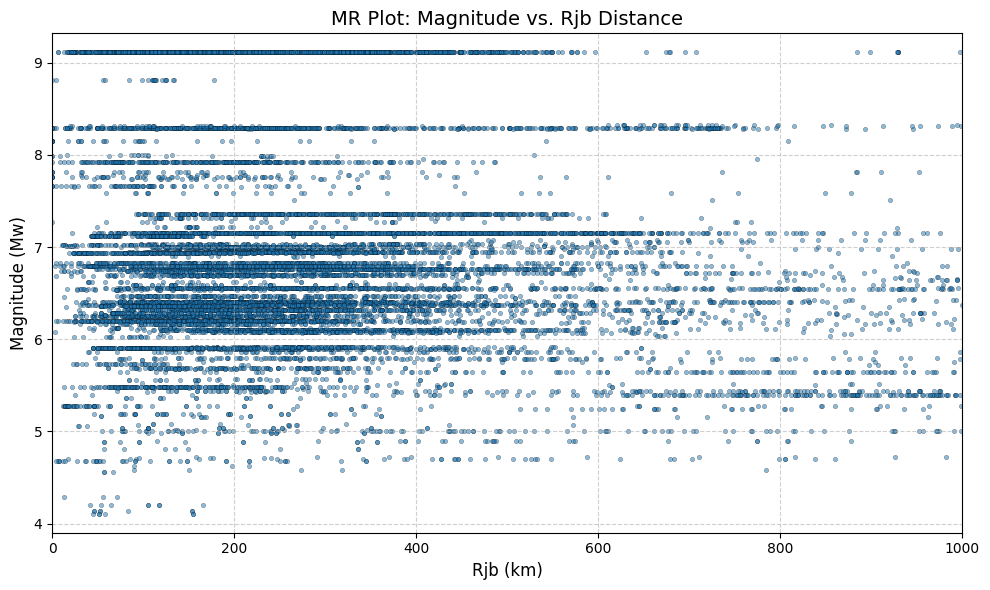

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['rjb'], df['mag'], s=10, alpha=0.5, edgecolors='k', linewidths=0.3)

plt.xlabel('Rjb (km)', fontsize=12)
plt.ylabel('Magnitude (Mw)', fontsize=12)
plt.title('MR Plot: Magnitude vs. Rjb Distance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1000)
plt.ylim(df['mag'].min() - 0.2, df['mag'].max() + 0.2)
plt.tight_layout()
plt.show()

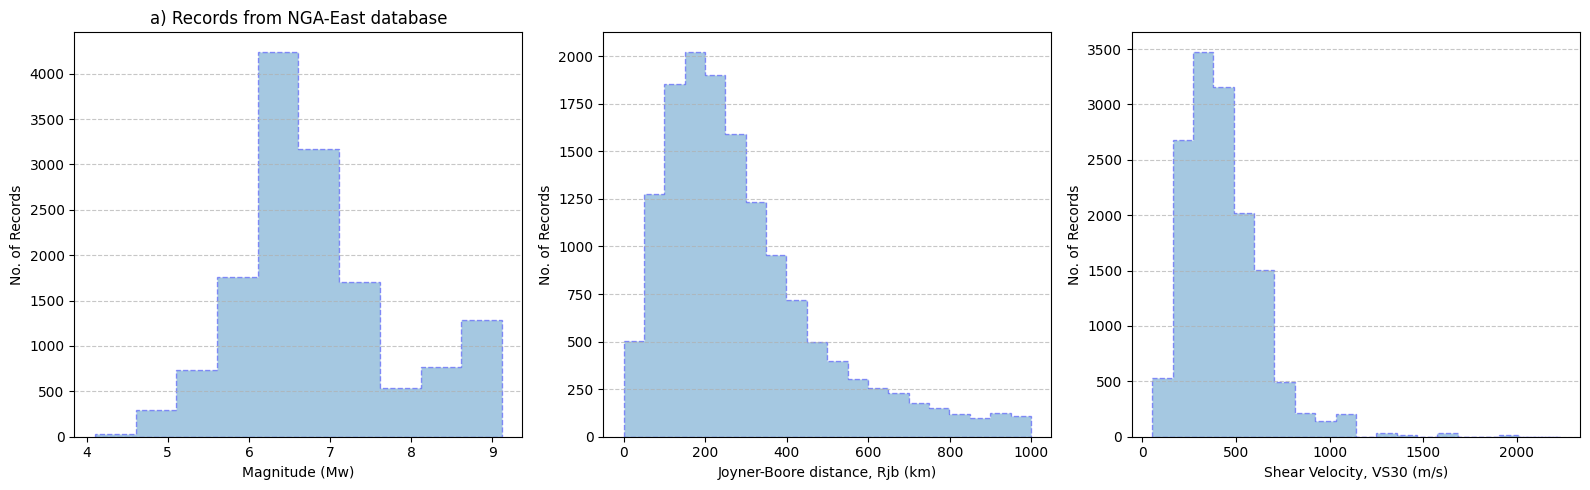

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].hist(df["mag"], bins=10, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[0].set_xlabel("Magnitude (Mw)")
axs[0].set_ylabel("No. of Records")
axs[0].set_title("a) Records from NGA-East database")
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1].hist(df["rjb"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[1].set_xlabel("Joyner-Boore distance, Rjb (km)")
axs[1].set_ylabel("No. of Records")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

axs[2].hist(df["vs30"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[2].set_xlabel("Shear Velocity, VS30 (m/s)")
axs[2].set_ylabel("No. of Records")
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import skew, kurtosis

def get_stats(df, columns):
    stats = {
        'min': df[columns].min(),
        'max': df[columns].max(),
        'mean': df[columns].mean(),
        'std': df[columns].std(),
        'skewness': df[columns].apply(skew),
        'kurtosis': df[columns].apply(kurtosis)
    }
    return pd.DataFrame(stats).T

table01_input = get_stats(df, input_cols)
table01_output = get_stats(df, target_cols)

print("Table 01 - Input Parameters:\n", table01_input.round(4))
print("\nTable 01 - Output Parameters:\n", table01_output.round(4))

Table 01 - Input Parameters:
              mag       rjb   logrjb  logvs30  intra_inter
min       4.1000    0.0100  -2.0000   1.7243       0.0000
max       9.1200  999.0898   2.9996   3.3483       1.0000
mean      6.8318  289.7475   2.3520   2.5906       0.4232
std       1.0028  196.9747   0.3695   0.2032       0.4941
skewness  0.7859    1.2926  -3.3307  -0.0870       0.3107
kurtosis  0.3906    1.5350  33.8885   0.1169      -1.9035

Table 01 - Output Parameters:
           T0pt010S  T0pt020S  T0pt030S  T0pt050S  T0pt075S  T0pt100S  \
min         0.0000    0.0000    0.0000    0.0000    0.0000    0.0000   
max         2.5801    2.7391    3.5567    4.9801    5.9791    3.6631   
mean        0.0304    0.0311    0.0330    0.0396    0.0499    0.0608   
std         0.0850    0.0884    0.0990    0.1280    0.1542    0.1829   
skewness    8.2602    8.5575   10.0383   11.3257   10.0677    7.6269   
kurtosis  120.2980  128.9357  190.2750  242.2775  208.1898   82.9457   

          T0pt150S  T0pt200

In [ ]:
results = []

for i, col in enumerate(target_cols):
    y_true = y_true_log[:, i]
    y_pred = y_pred_log[:, i]
    residuals = y_true - y_pred

    temp_df = pd.DataFrame({
        'event': EqIDs,
        'residuals': residuals
    })

    event_means = temp_df.groupby('event')['residuals'].mean()
    tau = event_means.std(ddof=0)

    phi_sq_list = []
    for _, group in temp_df.groupby('event'):
        res = group['residuals'].values
        if len(res) > 1:
            phi_sq_list.extend((res - res.mean())**2)
    phi = np.sqrt(np.mean(phi_sq_list))

    r2 = r2_score(y_true, y_pred)
    total = np.sqrt(tau**2 + phi**2)

    results.append({
        'Target Variable': col,
        'R2': r2,
        'Inter-Std (τ)': tau,
        'Intra-Std (φ)': phi,
        'Total Std': total
    })

table02 = pd.DataFrame(results).round(4)
print(table02)

   Target Variable      R2  Inter-Std (τ)  Intra-Std (φ)  Total Std
0         T0pt010S  0.8666         0.6708         0.6867     0.9600
1         T0pt020S  0.8658         0.6747         0.6897     0.9648
2         T0pt030S  0.8636         0.6878         0.6966     0.9790
3         T0pt050S  0.8541         0.7215         0.7298     1.0262
4         T0pt075S  0.8394         0.7575         0.7851     1.0910
5         T0pt100S  0.8315         0.7750         0.8195     1.1280
6         T0pt150S  0.8365         0.7490         0.8168     1.1083
7         T0pt200S  0.8434         0.7258         0.7941     1.0758
8         T0pt300S  0.8591         0.6866         0.7351     1.0058
9         T0pt400S  0.8675         0.6673         0.6985     0.9660
10        T0pt500S  0.8700         0.6459         0.6825     0.9397
11        T0pt750S  0.8645         0.6164         0.6784     0.9166
12        T1pt000S  0.8587         0.5980         0.6883     0.9118
13        T1pt500S  0.8487         0.5586       

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


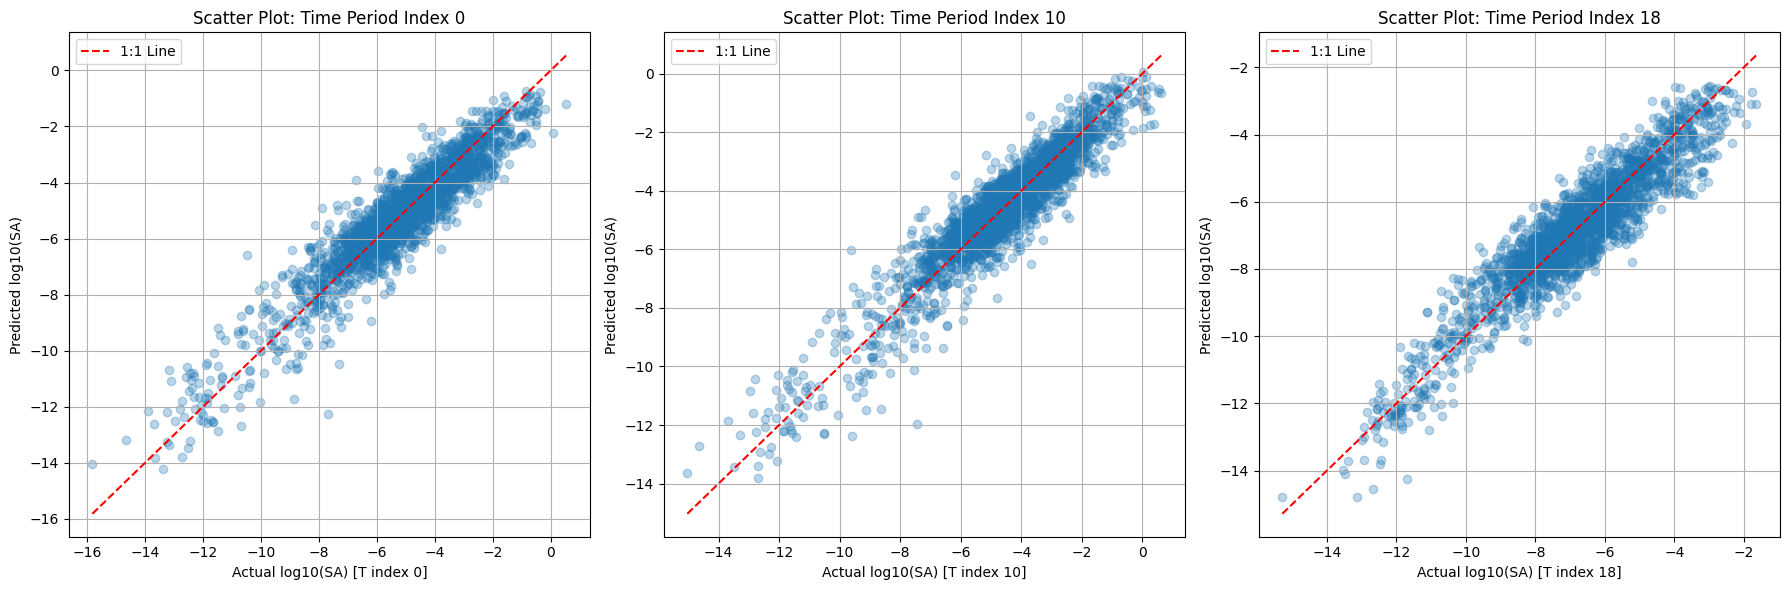

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

spectral_indices = [0, 10, 18]

# Get original log-space values (no exp if already in log)
Y_test_log = scaler_target.inverse_transform(y_test)
Y_pred_scaled = best_model.predict(X_test)
Y_pred_log = scaler_target.inverse_transform(Y_pred_scaled)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, idx in enumerate(spectral_indices):
    ax = axs[i]
    ax.scatter(Y_test_log[:, idx], Y_pred_log[:, idx], alpha=0.3)
    ax.plot([Y_test_log[:, idx].min(), Y_test_log[:, idx].max()],
            [Y_test_log[:, idx].min(), Y_test_log[:, idx].max()], 'r--', label='1:1 Line')

    ax.set_xlabel(f'Actual log10(SA) [T index {idx}]')
    ax.set_ylabel('Predicted log10(SA)')
    ax.set_title(f'Scatter Plot: Time Period Index {idx}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
from graphviz import Digraph

def draw_ann_architecture(input_features, output_targets):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='10')

    # Input Layer
    for i, feature in enumerate(input_features):
        dot.node(f'input_{i}', feature, shape='circle', style='filled', fillcolor='cornflowerblue')

    # Dense Layer 1 (with ELU activation)
    dot.node('dense1', 'Dense (64, ELU)', shape='box', style='filled', fillcolor='lightpink')

    # Batch Normalization Layer
    dot.node('batch_norm', 'BatchNorm', shape='box', style='filled', fillcolor='lightgray')

    # Dropout Layer
    dot.node('dropout', 'Dropout (0.2)', shape='box', style='filled', fillcolor='lightyellow')

    # Dense Layer 2 (with ELU activation)
    dot.node('dense2', 'Dense (32, ELU)', shape='box', style='filled', fillcolor='lightgreen')

    # Output Layer
    for j, target in enumerate(output_targets):
        dot.node(f'output_{j}', f'{target}', shape='circle', style='filled', fillcolor='palegreen')

    # Connections between layers
    for i in range(len(input_features)):
        dot.edge(f'input_{i}', 'dense1')
    dot.edge('dense1', 'batch_norm')
    dot.edge('batch_norm', 'dropout')
    dot.edge('dropout', 'dense2')
    for j in range(len(output_targets)):
        dot.edge('dense2', f'output_{j}')

    # Render to file
    dot.render('ann_model_architecture', cleanup=True)
    print("Diagram saved as 'ann_model_architecture.png'")

# Call the function with your variables
draw_ann_architecture(input_cols, target_cols)

Diagram saved as 'ann_model_architecture.png'


<ipython-input-50-99a96b4d1713>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby('bin')['x'].mean()
<ipython-input-50-99a96b4d1713>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('bin')['y'].mean()
<ipython-input-50-99a96b4d1713>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stds = df.groupby('bin')['y'].std()
<ipython-input-50-99a96b4d1713>:12: FutureWarning: T

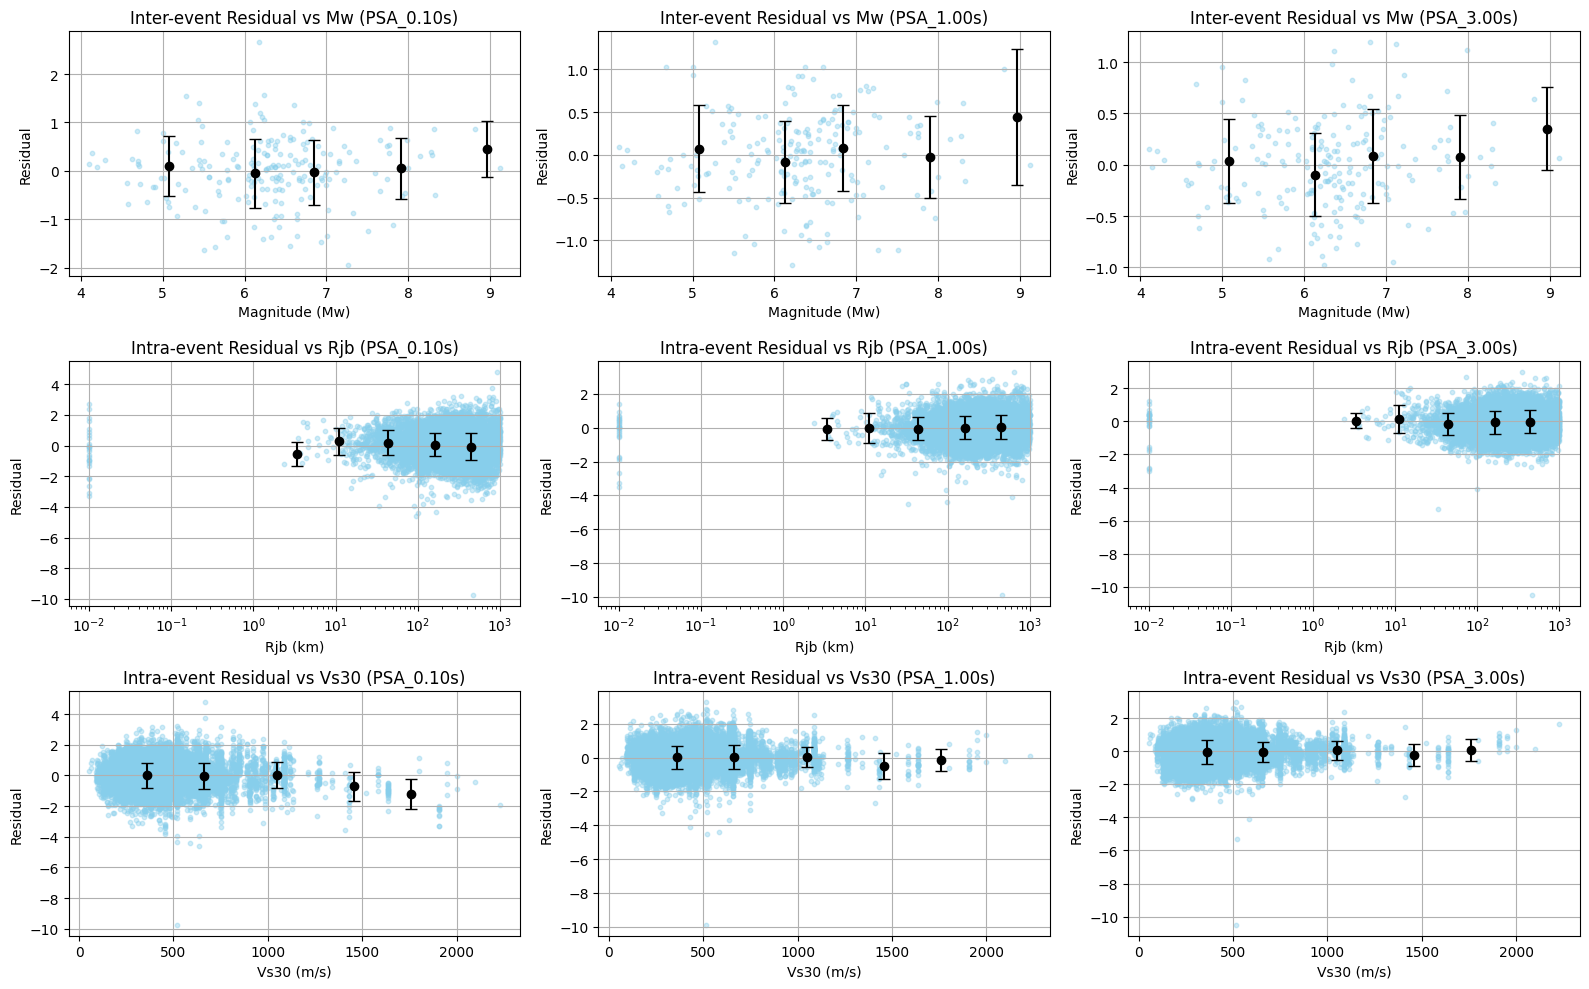

In [ ]:
time_periods = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4,
                0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]

selected_indices = [5, 12, 16]  # Modify based on your period selection
selected_labels = [f"PSA_{time_periods[i]:.2f}s" for i in selected_indices]

# Plotting function with binned mean/std
def plot_residual_binned(x, y, xlabel, title, log_x=False, bins=6, ax=None):
    df = pd.DataFrame({'x': x, 'y': y})
    df['bin'] = pd.cut(df['x'], bins=bins)

    bin_centers = df.groupby('bin')['x'].mean()
    bin_means = df.groupby('bin')['y'].mean()
    bin_stds = df.groupby('bin')['y'].std()

    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, s=10, color='skyblue')
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', capsize=4)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residual")
    ax.set_title(title)
    if log_x:
        ax.set_xscale("log")
    ax.grid(True)

# Plot setup
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

for col, i in enumerate(selected_indices):
    # Inter-event vs Mw
    eq_unique, eq_idx = np.unique(EqIDs, return_index=True)
    Mw_vals = df['mag'].values[eq_idx]
    plot_residual_binned(
        Mw_vals,
        inter_event[:, i],
        xlabel="Magnitude (Mw)",
        title=f"Inter-event Residual vs Mw ({selected_labels[col]})",
        bins=np.linspace(4.5, 9.5, 6),
        ax=axs[0, col]
    )

    # Intra-event vs Rjb
    plot_residual_binned(
        df['rjb'].values,
        intra_event[:, i],
        xlabel="Rjb (km)",
        title=f"Intra-event Residual vs Rjb ({selected_labels[col]})",
        bins=np.logspace(0, 3, 6),
        log_x=True,
        ax=axs[1, col]
    )

    # Intra-event vs Vs30
    plot_residual_binned(
        df['vs30'].values,
        intra_event[:, i],
        xlabel="Vs30 (m/s)",
        title=f"Intra-event Residual vs Vs30 ({selected_labels[col]})",
        bins=np.linspace(180, 2000, 6),
        ax=axs[2, col]
    )

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


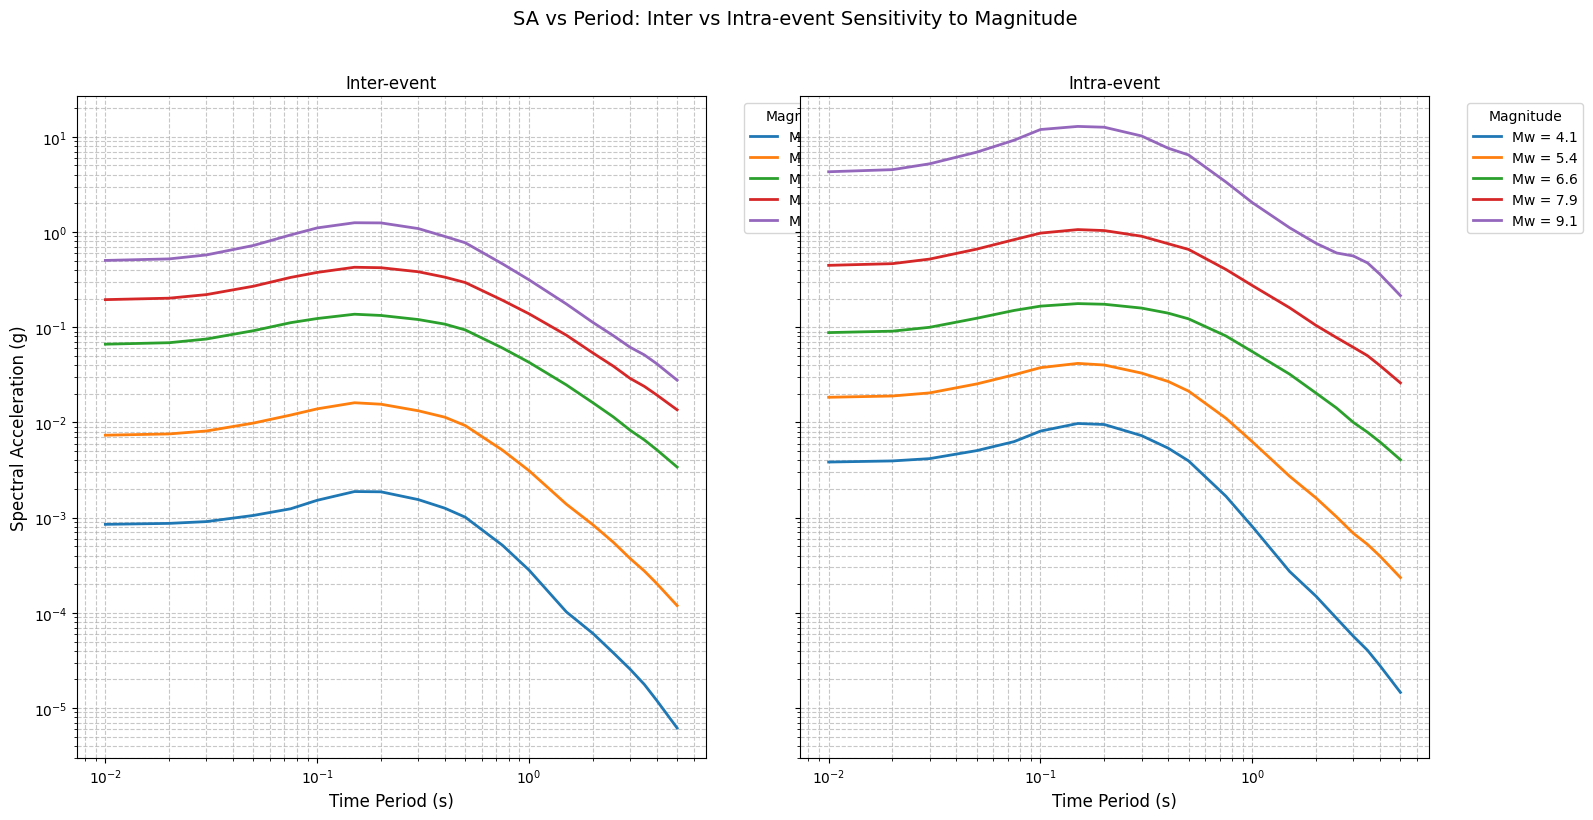

In [ ]:
periods = [float(t[1:].replace("pt", ".").replace("S", "")) for t in target_cols]

# Fixed values
fixed_rjb = 10.0
fixed_vs30 = 760.0
logrjb = np.log10(max(fixed_rjb, 0.01))
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Mw range from data
mw_range = np.linspace(df['mag'].min(), df['mag'].max(), 5)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)  # Increased figure size

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for mw in mw_range:
        X_input = np.array([[mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        y_pred_scaled = best_model.predict(X_scaled)
        y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
        y_pred = np.exp(y_pred_log)

        label = f'Mw = {mw:.1f}'
        ax.semilogy(periods, y_pred.flatten(), label=label, linewidth=2)  # Using semilogy for log scale

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=12)
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which="both", linestyle='--', alpha=0.7)
    ax.set_xscale('log')  # Log scale for x-axis if periods vary widely

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)

    # Adjust legend position and size
    ax.legend(title="Magnitude", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Magnitude", fontsize=14, y=1.02)
plt.tight_layout()

# Add more vertical space between plots if needed
plt.subplots_adjust(wspace=0.15)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


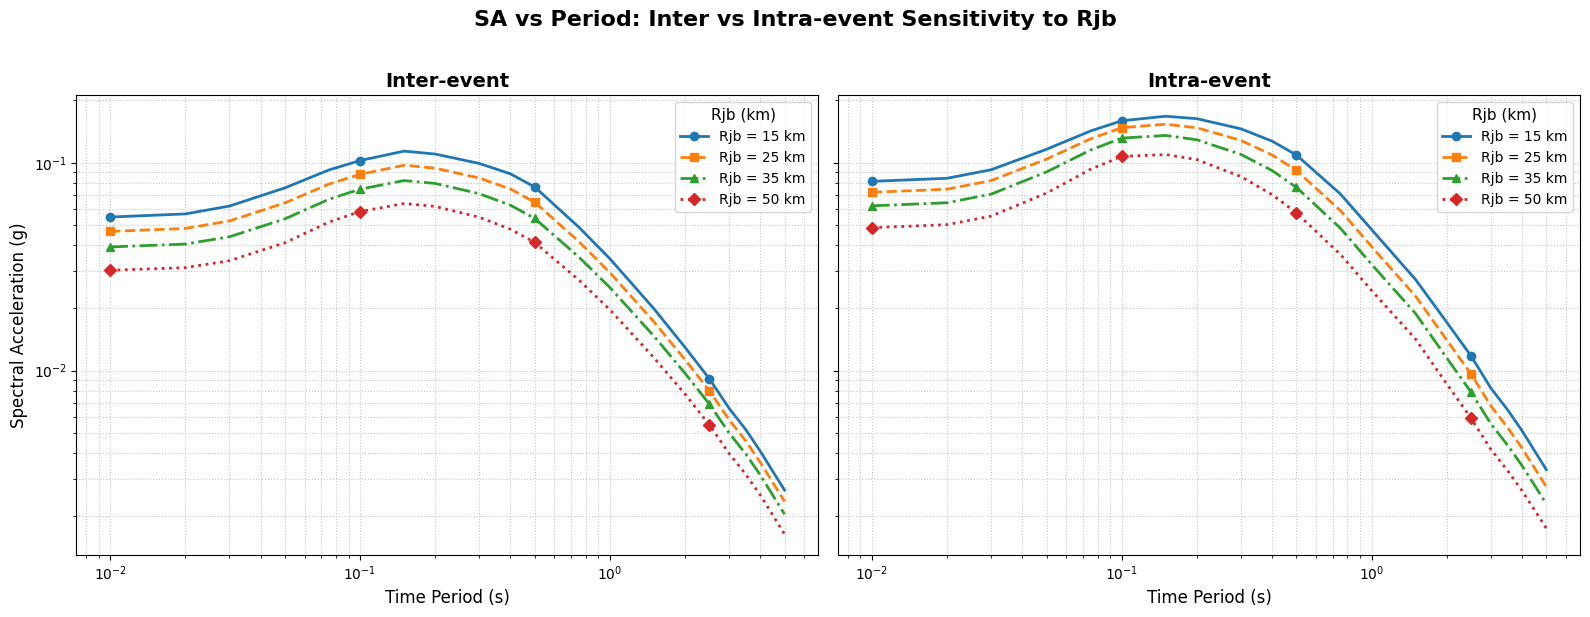

In [ ]:
fixed_mw = 6.5
fixed_vs30 = 760.0
logvs30 = np.log10(max(fixed_vs30, 0.01))

# Rjb values to test
rjb_values = [15,25,35,50]

# Define distinct line styles/markers for each Rjb
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]
    for i, rjb in enumerate(rjb_values):
        logrjb = np.log10(max(rjb, 0.01))
        X_input = np.array([[fixed_mw, rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        y_pred_scaled = best_model.predict(X_scaled)
        y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
        y_pred = np.exp(y_pred_log)

        label = f'Rjb = {rjb} km'
        # Plot with different style and marker for each Rjb
        ax.plot(periods, y_pred.flatten(),
                linestyle=line_styles[i%len(line_styles)],
                marker=markers[i%len(markers)],
                markevery=5,  # Show marker every 5 points
                linewidth=2,
                label=label)

    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event", fontsize=14, weight='bold')
    ax.set_xlabel("Time Period (s)", fontsize=12)
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12)
    ax.legend(title="Rjb (km)", fontsize=10, title_fontsize=11)

    # Set log scale if needed for better visibility
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.suptitle("SA vs Period: Inter vs Intra-event Sensitivity to Rjb",
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


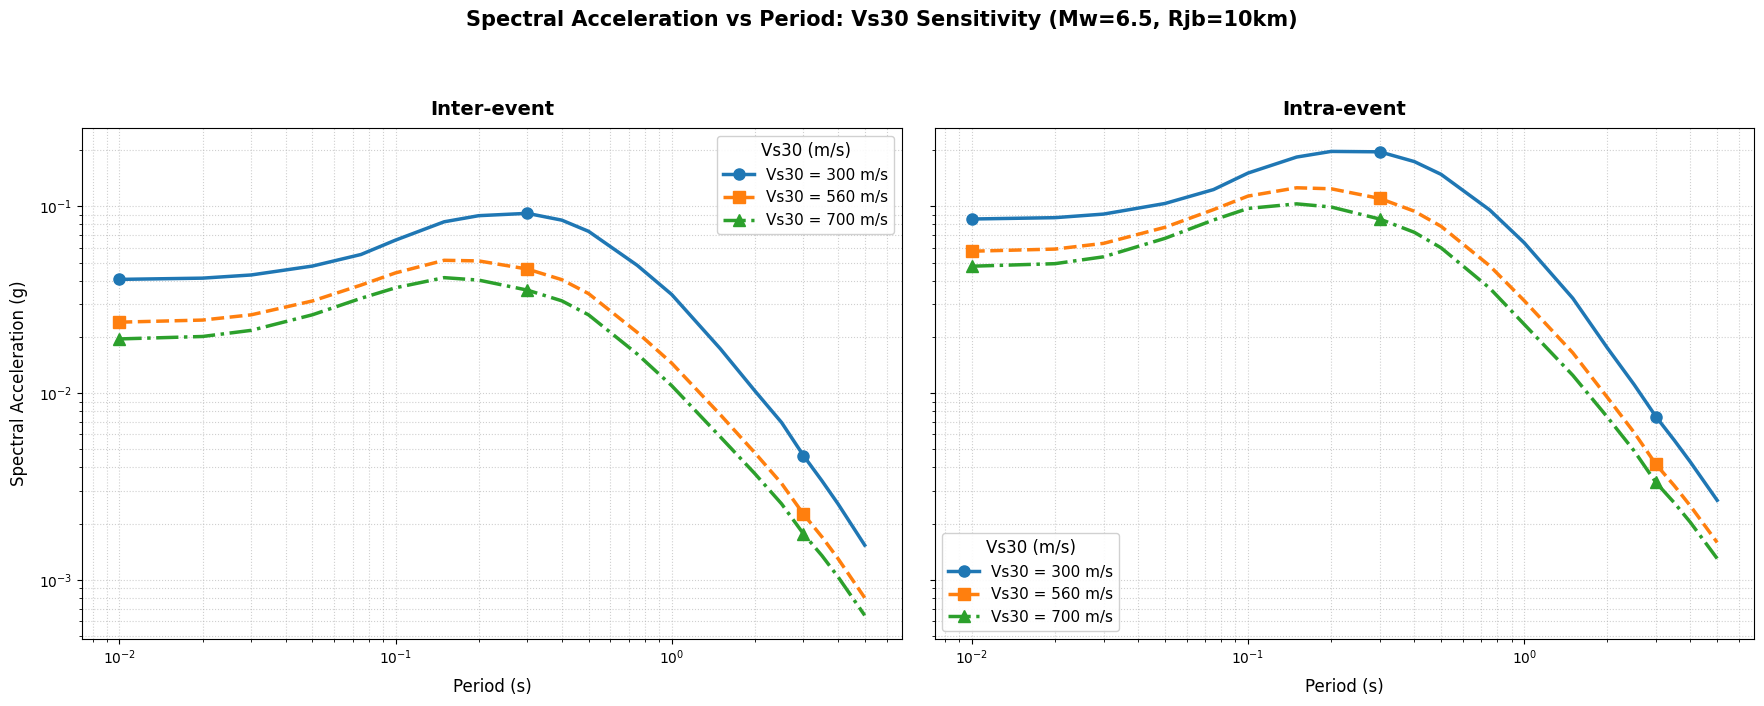

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fixed_mw = 6.0
fixed_rjb = 25.0
logrjb = np.log10(max(fixed_rjb, 0.01))

# Vs30 values to test
vs30_values = [300, 560, 700]

# Custom styling for each Vs30 curve
styles = {
    300: {'color': '#1f77b4', 'linestyle': '-', 'marker': 'o', 'linewidth': 2.5},
    560: {'color': '#ff7f0e', 'linestyle': '--', 'marker': 's', 'linewidth': 2.5},
    700: {'color': '#2ca02c', 'linestyle': '-.', 'marker': '^', 'linewidth': 2.5},
}

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for idx, intra_inter_val in enumerate([0, 1]):
    ax = axes[idx]

    for vs30 in vs30_values:
        logvs30 = np.log10(max(vs30, 0.01))
        X_input = np.array([[fixed_mw, fixed_rjb, logrjb, logvs30, intra_inter_val]])
        X_scaled = scaler_input.transform(X_input)
        y_pred_scaled = best_model.predict(X_scaled)
        y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
        y_pred = np.exp(y_pred_log)

        # Plot with custom style
        ax.plot(periods, y_pred.flatten(),
                label=f'Vs30 = {vs30} m/s',
                **styles[vs30],
                markersize=8,
                markevery=8)  # Show markers spaced out

    # Formatting
    ax.set_title("Inter-event" if intra_inter_val == 0 else "Intra-event",
                fontsize=14, pad=10, weight='bold')
    ax.set_xlabel("Period (s)", fontsize=12, labelpad=8)
    ax.grid(True, which='both', linestyle=':', alpha=0.6)

    if idx == 0:
        ax.set_ylabel("Spectral Acceleration (g)", fontsize=12, labelpad=8)

    # Logarithmic scales
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Legend with improved layout
    ax.legend(title="Vs30 (m/s)",
             fontsize=11,
             title_fontsize=12,
             framealpha=0.9,
             loc='upper right' if intra_inter_val == 0 else 'lower left')

# Main title with adjusted position
plt.suptitle("Spectral Acceleration vs Period: Vs30 Sensitivity (Mw=6.5, Rjb=10km)",
            fontsize=15, weight='bold', y=1.02)

plt.tight_layout(pad=2.0)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

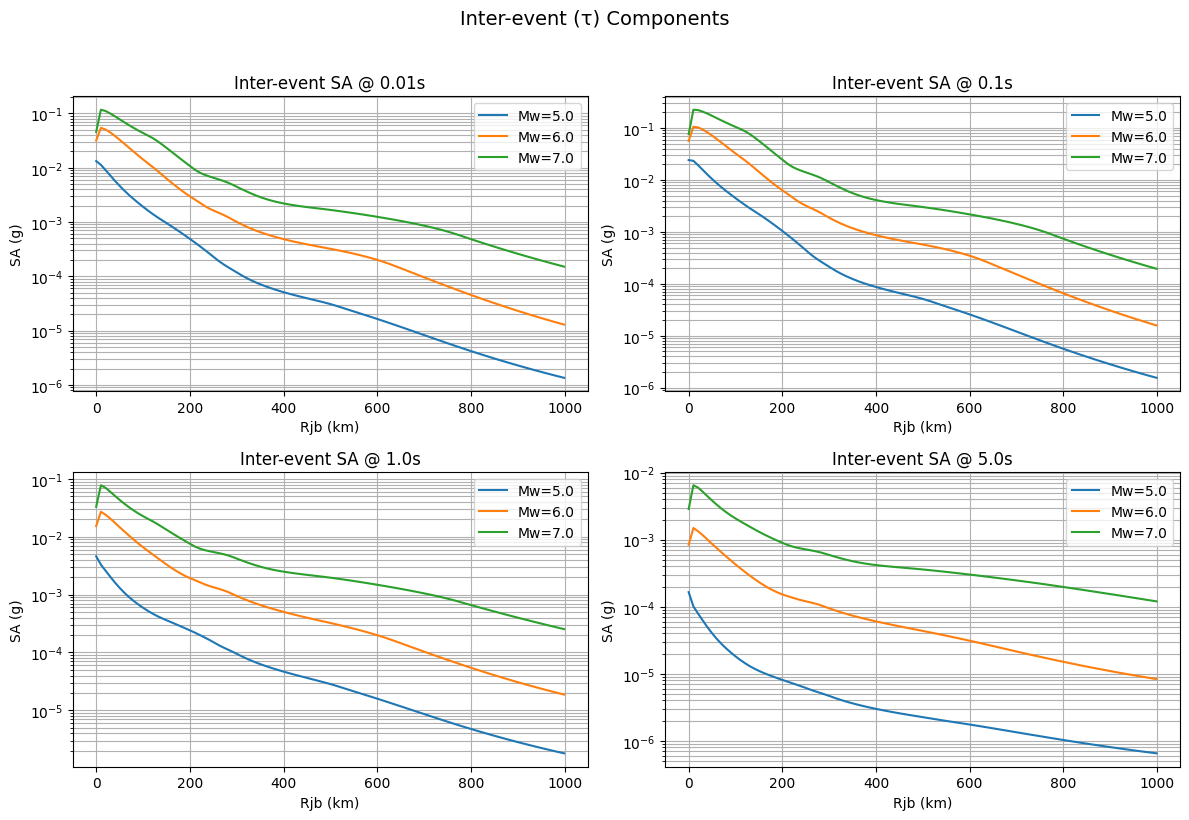

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

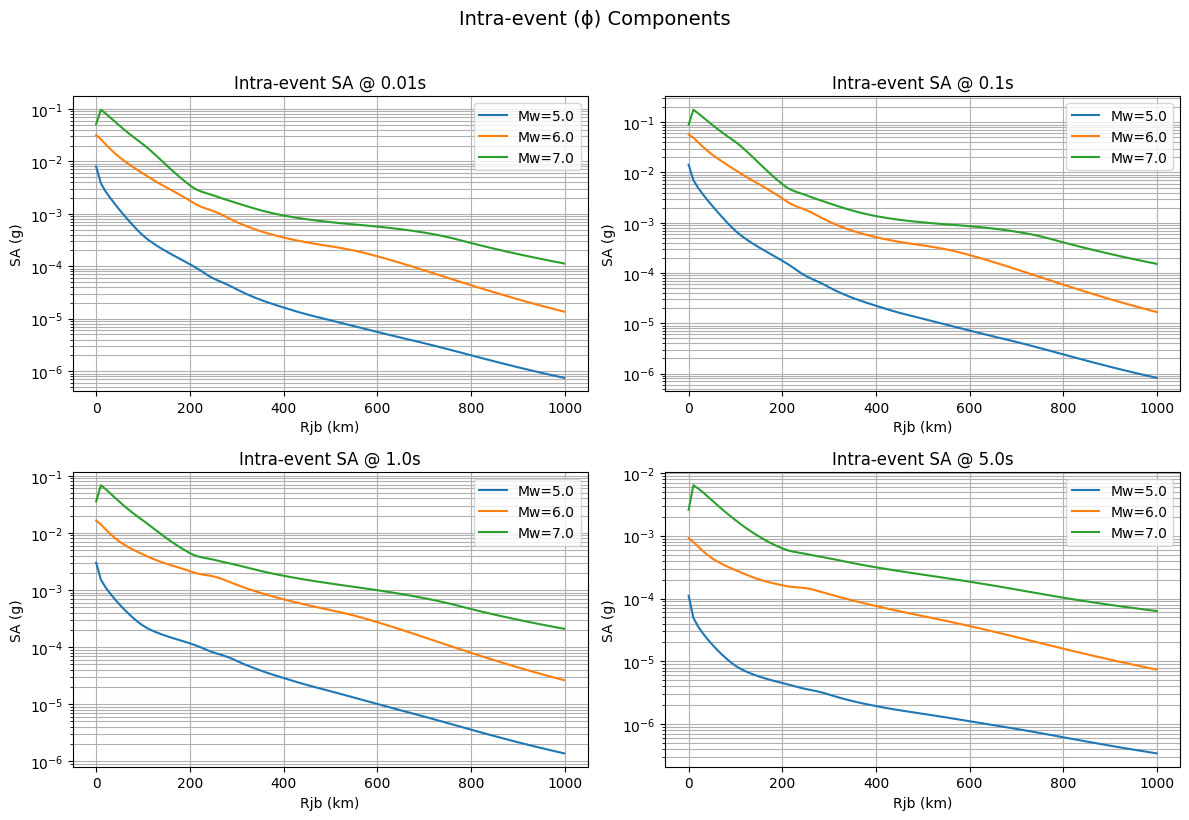

In [ ]:
selected_period_indices = [0, 5, 12, 19]
selected_periods = [float(target_cols[i][1:].replace('pt', '.').replace('S', '')) for i in selected_period_indices]

rjb_range = np.linspace(df['rjb'].min(), df['rjb'].max(), 100)
mw_values = [5.0, 6.0, 7.0]
fixed_vs30 = 760
logvs30 = np.log10(fixed_vs30)

plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 1]])  # 1 for inter-event
            X_scaled = scaler_input.transform(X_input)
            y_pred_scaled = best_model.predict(X_scaled)
            y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
            sa_values.append(np.exp(y_pred_log[0, iT]))

        plt.semilogy(rjb_range, sa_values, label=f'Mw={mw}')

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Inter-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Inter-event (τ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ==============================================
# 2. Second Figure: Intra-event (phi) Components
# ==============================================
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 0]])  # 0 for intra-event
            X_scaled = scaler_input.transform(X_input)
            y_pred_scaled = best_model.predict(X_scaled)
            y_pred_log = scaler_target.inverse_transform(y_pred_scaled)
            sa_values.append(np.exp(y_pred_log[0, iT]))

        plt.semilogy(rjb_range, sa_values, label=f'Mw={mw}')

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Intra-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Intra-event (ϕ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_12
Received: inputs=['Tensor(shape=(1000, 5))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_12
Received: inputs=['Tensor(shape=(2000, 5))']
  warnings.warn(msg)


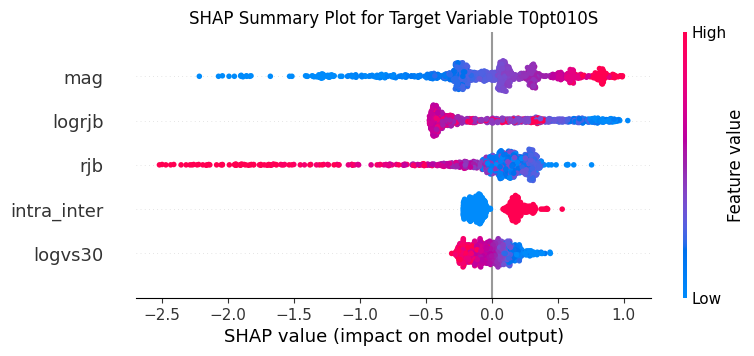

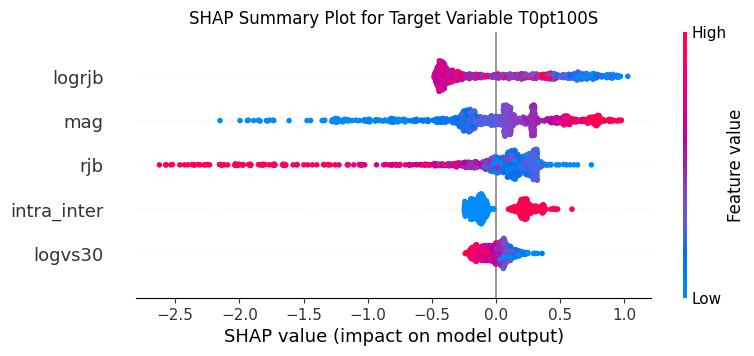

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.DeepExplainer(best_model, X_train[:1000])
shap_values = explainer.shap_values(X_val[:1000])

# Plot SHAP summary for only two specific output indices (e.g., 0 and 5)
for i in [0, 5]:
    shap.summary_plot(shap_values[:,:,i], X_val[:1000], feature_names=input_cols, show=False)
    plt.title(f"SHAP Summary Plot for Target Variable {target_cols[i]}")
    plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━

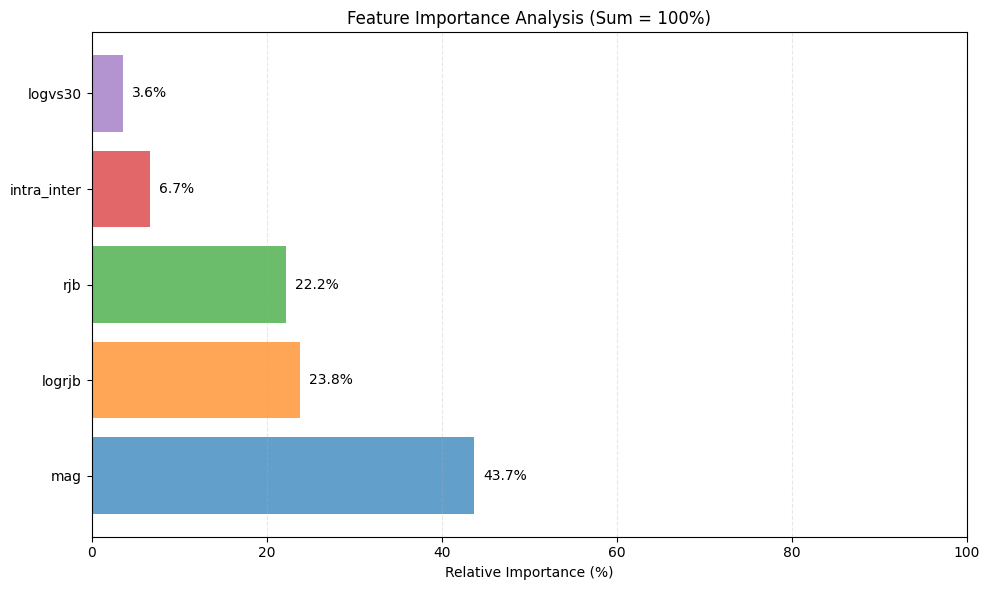

Sum of importance values: 100.0%


In [ ]:
from sklearn.inspection import permutation_importance

def scoring_fn(estimator, X, y):
    y_pred = estimator.predict(X)
    mse_per_period = np.mean((y - y_pred) ** 2, axis=0)
    return -np.mean(mse_per_period)

# Compute permutation importance
result = permutation_importance(
    best_model,
    X_val,
    y_val,
    scoring=scoring_fn,
    n_repeats=10,
    random_state=42
)

# Calculate raw and normalized importances
feature_importance = result.importances_mean
total_importance = np.sum(np.abs(feature_importance))
normalized_importance = np.round((feature_importance / total_importance) * 100, 1)

# Adjust last value for exact 100%
normalized_importance[-1] += 100 - np.round(np.sum(normalized_importance),1)

# Sort features
sorted_idx = np.argsort(normalized_importance)[::-1]
sorted_features = np.array(input_cols)[sorted_idx]
sorted_importance = normalized_importance[sorted_idx]

# Plotting
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = plt.barh(range(len(sorted_features)), sorted_importance, color=colors, alpha=0.7)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}%", va='center', ha='left')

plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlim(0, 100)
plt.xlabel("Relative Importance (%)")
plt.title("Feature Importance Analysis (Sum = 100%)")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Print exact total
print(f"Sum of importance values: {np.round(np.sum(normalized_importance), 4)}%")